# Model training lab

This is the notebook for loading and training models.
Furthermore it provides simple documentation for different approaches used for training a model.

Run the command below to see command-completion on pressing `TAB`.

## Prerequisits

In [1]:
# Imports
import os
import warnings
import tools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from matplotlib import pyplot

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root CSV files directory
dirname = "./data/"

# Constant frame count.
frames = 100

## Preparation Stage
### Load data and normalize
For training it's required to extend/reduce every dataset to n frames, where n is `frames`.

In [2]:
listfile = os.listdir(dirname)
data = []
for wordname in listfile:
    if wordname == ".DS_Store":
        continue
    for csv in os.listdir(dirname + wordname):
        filepath = os.path.join(dirname, wordname, csv)
        content = pd.read_csv(filepath, sep=';')
        content = content.reindex(list(range(0, frames)), fill_value=0.0)
        content.fillna(0.0, inplace = True) 
        data.append((wordname, content))


In [3]:
# Print the content of the first dataframe
data[10][0]

'Computer'

### Split data
Split the dataset up into the following segments:
1. Training Data: 60%
2. Validation Data: 20%
3. Test Data: 20%


In [4]:
features = [n[1] for n in data]
features = [f.to_numpy() for f in features]
labels = [n[0] for n in data]
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=42)

In [5]:
def printCountDataSets(dataset):
    wortCounter = []
    #Liste mit einmaligen Labels erstellen
    labels = sorted(set(dataset), key=dataset.index)
    #Liste nochmal Alphabetisch sortieren
    labels = sorted(labels)
    for label in labels:
        wortCounter.append(0)
    for row in dataset:
        for i in range(len(labels)):
            if str(labels[i]).startswith(row):
                wortCounter[i] += 1
    for i in range(len(labels)):
        print(labels[i], ': ', wortCounter[i], end =";  ")
    print(' ')
        
        
print('Alle Klassensätze')
printCountDataSets(labels)
print('Trainings Klassensätze')
printCountDataSets(y_train)
print('Test Klassensätze')
printCountDataSets(y_test) 
print('Validation Klassensätze')
printCountDataSets(y_val)  

Alle Klassensätze
Computer :  127;  Deutschland :  124;  Haben :  71;  Hallo :  123;  Mainz :  71;  Software :  70;  Welt :  123;  du :  71;  ich :  71;  unser :  71;  zeigen :  71;   
Trainings Klassensätze
Computer :  75;  Deutschland :  72;  Haben :  43;  Hallo :  79;  Mainz :  48;  Software :  44;  Welt :  73;  du :  37;  ich :  32;  unser :  50;  zeigen :  42;   
Test Klassensätze
Computer :  27;  Deutschland :  23;  Haben :  17;  Hallo :  23;  Mainz :  14;  Software :  14;  Welt :  23;  du :  10;  ich :  21;  unser :  11;  zeigen :  16;   
Validation Klassensätze
Computer :  25;  Deutschland :  29;  Haben :  11;  Hallo :  21;  Mainz :  9;  Software :  12;  Welt :  27;  du :  24;  ich :  18;  unser :  10;  zeigen :  13;   


In [7]:
# Display data distribution
print("Total:", len(labels))
print("Training:", len(y_train), len(y_train) / len(labels) * 100)
print("Val:", len(y_val), len(y_val) / len(labels) * 100)
print("Test:", len(y_test), len(y_test) / len(labels) * 100)

Total: 993
Training: 595 59.91943605236657
Val: 199 20.040281973816718
Test: 199 20.040281973816718


### Tokenize (One Hot)

In [8]:
tokenizer = tools.tokenize(dirname)
print(tokenizer.word_index)
encoded_train=tokenizer.texts_to_sequences([y_train])[0]
encoded_val=tokenizer.texts_to_sequences([y_val])[0]
encoded_test=tokenizer.texts_to_sequences([y_test])[0]
y_train = to_categorical(encoded_train)
y_val = to_categorical(encoded_val)
y_test = to_categorical(encoded_test)
print(y_train)

{'computer': 1, 'deutschland': 2, 'du': 3, 'haben': 4, 'hallo': 5, 'ich': 6, 'mainz': 7, 'software': 8, 'unser': 9, 'welt': 10, 'zeigen': 11}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [9]:
# Making numpy arrays
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [10]:
print(x_train)

[[[0.464727  0.0802216 0.51021   ... 0.        0.        0.       ]
  [0.468408  0.122253  0.420319  ... 0.        0.        0.       ]
  [0.462211  0.117836  0.396451  ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.52613   0.302176  0.227828  ... 0.        0.        0.       ]
  [0.527445  0.30221   0.239347  ... 0.        0.        0.       ]
  [0.518558  0.316052  0.257128  ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.46422   0.326161  0.792549  ... 0.72014   0.128272  0.738572 ]
  [0.463434  0.327905  0.179201  ... 0.        0.        0.       ]
  [0.4619    0.32941   0.230538 

## Training Stage
Configure the model and train it.

Metrics:
<div float="right">
    <img src="assets/accuracy.png" width="400"> 
    <img src="assets/precision_recall_formula.png" width="400">
</div>
<img src="assets/precision_recall.png" width="1000">

### Configure model
Configures the model with the specified parameters.

#### LSTM

In [11]:
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(layers.LSTM(32))  # return a single vector of dimension 32
#model.add(layers.LSTM(16))  # return a single vector of dimension 32
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

### or
#### Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(100, 86)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

### or
#### Simple RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(200, 42)))
model.add(Dense(64, activation="softmax")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(128, activation="linear")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(21))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### Train

In [12]:
history=model.fit(x_train,y_train,epochs=80,validation_data=(x_val,y_val),shuffle=False)

Train on 595 samples, validate on 199 samples
Epoch 1/80
595/595 [==============================] - 9s 15ms/sample - loss: 2.4722 - accuracy: 0.1311 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3984 - val_accuracy: 0.1256 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/80
595/595 [==============================] - 1s 986us/sample - loss: 2.3901 - accuracy: 0.1361 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3849 - val_accuracy: 0.1256 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/80
595/595 [==============================] - 1s 974us/sample - loss: 2.3784 - accuracy: 0.1328 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3862 - val_accuracy: 0.1055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/80
595/595 [==============================] - 1s 965us/sample - loss: 2.3789 - accuracy: 0.1479 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3723 - val_accuracy: 0.1256 - val_precision: 0.0000e+00 - va

Epoch 36/80
595/595 [==============================] - 1s 1ms/sample - loss: 1.6443 - accuracy: 0.3950 - precision: 0.7158 - recall: 0.1143 - val_loss: 1.6603 - val_accuracy: 0.4523 - val_precision: 0.8000 - val_recall: 0.1206
Epoch 37/80
595/595 [==============================] - 1s 1ms/sample - loss: 1.6530 - accuracy: 0.4067 - precision: 0.6900 - recall: 0.1160 - val_loss: 1.6594 - val_accuracy: 0.4472 - val_precision: 0.9048 - val_recall: 0.0955
Epoch 38/80
595/595 [==============================] - 1s 973us/sample - loss: 1.5771 - accuracy: 0.4235 - precision: 0.7447 - recall: 0.1176 - val_loss: 1.6277 - val_accuracy: 0.4422 - val_precision: 0.7576 - val_recall: 0.2513
Epoch 39/80
595/595 [==============================] - 1s 989us/sample - loss: 1.5986 - accuracy: 0.4101 - precision: 0.7214 - recall: 0.1697 - val_loss: 1.6423 - val_accuracy: 0.4271 - val_precision: 0.9400 - val_recall: 0.2362
Epoch 40/80
595/595 [==============================] - 1s 983us/sample - loss: 1.5328 - 

Epoch 72/80
595/595 [==============================] - 1s 993us/sample - loss: 0.8755 - accuracy: 0.6706 - precision: 0.8199 - recall: 0.4975 - val_loss: 0.9778 - val_accuracy: 0.6533 - val_precision: 0.8125 - val_recall: 0.4573
Epoch 73/80
595/595 [==============================] - 1s 974us/sample - loss: 0.9387 - accuracy: 0.6487 - precision: 0.8022 - recall: 0.4975 - val_loss: 1.0083 - val_accuracy: 0.6633 - val_precision: 0.8276 - val_recall: 0.4824
Epoch 74/80
595/595 [==============================] - 1s 969us/sample - loss: 0.8094 - accuracy: 0.7160 - precision: 0.8249 - recall: 0.5462 - val_loss: 1.0084 - val_accuracy: 0.6432 - val_precision: 0.8070 - val_recall: 0.4623
Epoch 75/80
595/595 [==============================] - 1s 966us/sample - loss: 0.9268 - accuracy: 0.6756 - precision: 0.8368 - recall: 0.5429 - val_loss: 1.0650 - val_accuracy: 0.6131 - val_precision: 0.6825 - val_recall: 0.4322
Epoch 76/80
595/595 [==============================] - 1s 986us/sample - loss: 0.854

### Diagnostic Plots

The training history of your LSTM models can be used to diagnose the behavior of your model.

You can plot the performance of your model using the Matplotlib library. For example, you can plot training loss vs test loss as follows:

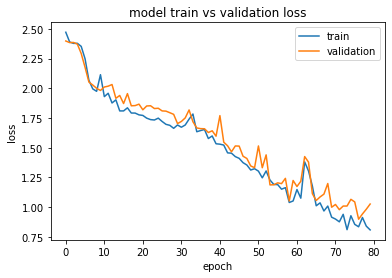

In [13]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#### Underfit Example
Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.


<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model.png" width="400">


Running this example shows the characteristic of an underfit model that appears under-provisioned.
In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model-via-Status.png" width="400">

#### Good Fit Example
Running the example creates a line plot showing the train and validation loss meeting.
Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

<img src="assets/Diagnostic-Line-Plot-Showing-a-Good-Fit-for-a-Model.png" width="400">

#### Overfit Example
Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.
This may be a sign of too many training epochs.
In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Overfit-Model.png" width="400">

### Evaluate

In [14]:
model.evaluate(x=x_test, y=y_test)

199/199 [==============================] - 0s 576us/sample - loss: 1.1315 - accuracy: 0.5829 - precision: 0.7188 - recall: 0.4623


[1.1315479850649235, 0.5829146, 0.71875, 0.46231157]

### Save model

In [17]:
model.save("sign_lang_recognition.h5")